#info

### **Project: Predict Student Performance from Game Play**

#### Project Link:
[Predict Student Performance from Game Play](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview)

#### Challenge Description:
The goal of this competition is to predict student performance during game-based learning in real-time. Participants are tasked with developing a model trained on a substantial open dataset of game logs. The challenge involves using time series data generated by an online educational game to determine whether players will answer questions correctly. This prediction is essential for advancing research into knowledge-tracing methods for game-based learning and supporting developers in creating more effective educational games.

**TLDR: "For each <session_id>_<question #>, you are predicting the correct column, identifying whether you believe the user for this particular session will answer this question correctly, using only the previous information for the session."**

#### Data Description:
The dataset comprises game logs from the Jo Wilder online educational game. It includes time series data representing student interactions within the game. At specific checkpoints (level 4, level 12, and level 22), the dataset includes questions that players must answer. For each checkpoint, all previous test data for that section is available. The primary objective is to use this historical data to predict the correctness of students' answers at these checkpoints.

#### Type of Machine Learning:
This project involves Supervised Classification. Specifically, it is a binary classification task where the model predicts whether a student will answer a question correctly (1) or incorrectly (0).

#### Context:
Game-based learning integrates educational content into a game framework, making the learning process enjoyable and interactive. Despite its growing use in educational settings, the availability of open datasets to apply data science and learning analytics principles to improve game-based learning is limited. This competition aims to fill that gap by providing a large dataset of game logs, fostering the development of models that can enhance the effectiveness of educational games and contribute to the field of knowledge-tracing in game-based learning.

#setup

In [1]:
pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [3]:
!chmod 600 ~/.kaggle/kaggle.json
#set permissions

In [4]:
pip install missingno

In [5]:
import math
import scipy
import glob
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [6]:
!kaggle competitions download -c predict-student-performance-from-game-play
!unzip predict-student-performance-from-game-play.zip -d predict-student-performance-from-game-play

100% 968M/968M [00:52<00:00, 20.4MB/s]
100% 968M/968M [00:52<00:00, 19.3MB/s]
Archive:  predict-student-performance-from-game-play.zip
  inflating: predict-student-performance-from-game-play/jo_wilder/__init__.py  
  inflating: predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: predict-student-performance-from-game-play/jo_wilder_310/__init__.py  
  inflating: predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: predict-student-performance-from-game-play/sample_submission.csv  
  inflating: predict-student-performance-from-game-play/test.csv  
  inflating: predict-student-performance-from-game-play/train.csv  
  inflating: predict-student-performance-from-game-play/train_labels.csv  


In [7]:
!ls -lh sample_data

total 55M
-rwxr-xr-x 1 root root 1.7K Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root 295K Aug  2 13:24 california_housing_test.csv
-rw-r--r-- 1 root root 1.7M Aug  2 13:24 california_housing_train.csv
-rw-r--r-- 1 root root  18M Aug  2 13:24 mnist_test.csv
-rw-r--r-- 1 root root  35M Aug  2 13:24 mnist_train_small.csv
-rwxr-xr-x 1 root root  930 Jan  1  2000 README.md


#load dfs

In [8]:
traindf = pd.read_csv("predict-student-performance-from-game-play/train.csv")

In [ ]:
traindf


session_id  index  elapsed_time      event_name       name  \
0         20090312431273200      0             0  cutscene_click      basic   
1         20090312431273200      1          1323    person_click      basic   
2         20090312431273200      2           831    person_click      basic   
3         20090312431273200      3          1147    person_click      basic   
4         20090312431273200      4          1863    person_click      basic   
...                     ...    ...           ...             ...        ...   
26296941  22100221145014656   1600       5483231  navigate_click  undefined   
26296942  22100221145014656   1601       5485166  navigate_click  undefined   
26296943  22100221145014656   1602       5485917  navigate_click  undefined   
26296944  22100221145014656   1603       5486753  navigate_click  undefined   
26296945  22100221145014656   1604       5487952      checkpoint      basic   

          level  page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0             0   NaN  -413.991405  -159.314686          380.0          494.0   
1             0   NaN  -413.991405  -159.314686          380.0          494.0   
2             0   NaN  -413.991405  -159.314686          380.0          494.0   
3             0   NaN  -413.991405  -159.314686          380.0          494.0   
4             0   NaN  -412.991405  -159.314686          381.0          494.0   
...         ...   ...          ...          ...            ...            ...   
26296941     22   NaN   343.887291    36.701026          483.0          273.0   
26296942     22   NaN   332.696070   141.493178          545.0          221.0   
26296943     22   NaN   369.912859   140.569205          611.0          217.0   
26296944     22   NaN   252.299653   123.805889          526.0          232.0   
26296945     22   NaN          NaN          NaN            NaN            NaN   

          hover_duration                           text            fqid  \
0                    NaN                      undefined           intro   
1                    NaN  Whatcha doing over there, Jo?          gramps   
2                    NaN         Just talking to Teddy.          gramps   
3                    NaN     I gotta run to my meeting!          gramps   
4                    NaN            Can I come, Gramps?          gramps   
...                  ...                            ...             ...   
26296941             NaN                            NaN             NaN   
26296942             NaN                            NaN  chap4_finale_c   
26296943             NaN                            NaN             NaN   
26296944             NaN                            NaN  chap4_finale_c   
26296945             NaN                            NaN  chap4_finale_c   

                               room_fqid  \
0         tunic.historicalsociety.closet   
1         tunic.historicalsociety.closet   
2         tunic.historicalsociety.closet   
3         tunic.historicalsociety.closet   
4         tunic.historicalsociety.closet   
...                                  ...   
26296941            tunic.capitol_2.hall   
26296942            tunic.capitol_2.hall   
26296943            tunic.capitol_2.hall   
26296944            tunic.capitol_2.hall   
26296945            tunic.capitol_2.hall   

                                                  text_fqid  fullscreen  hq  \
0                      tunic.historicalsociety.closet.intro           0   0   
1         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
2         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
3         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
4         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
...                                                     ...         ...  ..   
26296941                                                NaN           0   0   
26296942                         

In [9]:
labdf = pd.read_csv("predict-student-performance-from-game-play/train_labels.csv")
labdf

session_id  correct
0        20090312431273200_q1        1
1        20090312433251036_q1        0
2        20090312455206810_q1        1
3        20090313091715820_q1        0
4        20090313571836404_q1        1
...                       ...      ...
424111  22100215342220508_q18        1
424112  22100215460321130_q18        1
424113  22100217104993650_q18        1
424114  22100219442786200_q18        1
424115  22100221145014656_q18        1

[424116 rows x 2 columns]

In [10]:
samdf = pd.read_csv("predict-student-performance-from-game-play/sample_submission.csv")
samdf

session_id  correct  session_level
0    20090109393214576_q1        0              0
1    20090312143683264_q1        0              3
2    20090312331414616_q1        0              6
3    20090109393214576_q2        0              0
4    20090312143683264_q2        0              3
5    20090312331414616_q2        0              6
6    20090109393214576_q3        0              0
7    20090312143683264_q3        0              3
8    20090312331414616_q3        0              6
9    20090109393214576_q4        0              1
10   20090312143683264_q4        0              4
11   20090312331414616_q4        0              7
12   20090109393214576_q5        0              1
13   20090312143683264_q5        0              4
14   20090312331414616_q5        0              7
15   20090109393214576_q6        0              1
16   20090312143683264_q6        0              4
17   20090312331414616_q6        0              7
18   20090109393214576_q7        0              1
19   20090312143683264_q7        0              4
20   20090312331414616_q7        0              7
21   20090109393214576_q8        0              1
22   20090312143683264_q8        0              4
23   20090312331414616_q8        0              7
24   20090109393214576_q9        0              1
25   20090312143683264_q9        0              4
26   20090312331414616_q9        0              7
27  20090109393214576_q10        0              1
28  20090312143683264_q10        0              4
29  20090312331414616_q10        0              7
30  20090109393214576_q11        0              1
31  20090312143683264_q11        0              4
32  20090312331414616_q11        0              7
33  20090109393214576_q12        0              1
34  20090312143683264_q12        0              4
35  20090312331414616_q12        0              7
36  20090109393214576_q13        0              1
37  20090312143683264_q13        0              4
38  20090312331414616_q13        0              7
39  20090109393214576_q14        0              2
40  20090312143683264_q14        0              5
41  20090312331414616_q14        0              8
42  20090109393214576_q15        0              2
43  20090312143683264_q15        0              5
44  20090312331414616_q15        0              8
45  20090109393214576_q16        0              2
46  20090312143683264_q16        0              5
47  20090312331414616_q16        0              8
48  20090109393214576_q17        0              2
49  20090312143683264_q17        0              5
50  20090312331414616_q17        0              8
51  20090109393214576_q18        0              2
52  20090312143683264_q18        0              5
53  20090312331414616_q18        0              8

In [11]:
testdf = pd.read_csv("predict-student-performance-from-game-play/test.csv")
testdf

session_id  index  elapsed_time      event_name       name  \
0     20090109393214576      0             0  cutscene_click      basic   
1     20090109393214576      1          1965    person_click      basic   
2     20090109393214576      2          3614    person_click      basic   
3     20090109393214576      3          5330    person_click      basic   
4     20090109393214576      4          6397    person_click      basic   
...                 ...    ...           ...             ...        ...   
3723  20090312331414616   1001       1581679       map_hover      basic   
3724  20090312331414616   1002       1583044       map_hover      basic   
3725  20090312331414616   1003       1583410       map_click  undefined   
3726  20090312331414616   1004       1585841  navigate_click  undefined   
3727  20090312331414616   1005       1587810      checkpoint      basic   

      level  page  room_coor_x  room_coor_y  screen_coor_x  ...  \
0         0   NaN  -413.991405    75.685314          380.0  ...   
1         0   NaN  -105.991405   -63.314686          688.0  ...   
2         0   NaN  -418.991405    47.685314          375.0  ...   
3         0   NaN  -110.991405   -57.314686          683.0  ...   
4         0   NaN  -110.991405   -57.314686          683.0  ...   
...     ...   ...          ...          ...            ...  ...   
3723     22   NaN          NaN          NaN            NaN  ...   
3724     22   NaN          NaN          NaN            NaN  ...   
3725     22   NaN   483.726363    -3.880047          456.0  ...   
3726     22   NaN   192.372139    38.216178          383.0  ...   
3727     22   NaN          NaN          NaN            NaN  ...   

      hover_duration                           text             fqid  \
0                NaN                      undefined            intro   
1                NaN  Whatcha doing over there, Jo?           gramps   
2                NaN         Just talking to Teddy.           gramps   
3                NaN     I gotta run to my meeting!           gramps   
4                NaN            Can I come, Gramps?           gramps   
...              ...                            ...              ...   
3723           484.0                            NaN   tunic.wildlife   
3724           783.0                            NaN  tunic.capitol_2   
3725             NaN                            NaN  tunic.capitol_2   
3726             NaN                            NaN   chap4_finale_c   
3727             NaN                            NaN   chap4_finale_c   

                           room_fqid  \
0     tunic.historicalsociety.closet   
1     tunic.historicalsociety.closet   
2     tunic.historicalsociety.closet   
3     tunic.historicalsociety.closet   
4     tunic.historicalsociety.closet   
...                              ...   
3723   tunic.historicalsociety.entry   
3724   tunic.historicalsociety.entry   
3725   tunic.historicalsociety.entry   
3726            tunic.capitol_2.hall   
3727            tunic.capitol_2.hall   

                                              text_fqid fullscreen  hq  music  \
0                  tunic.historicalsociety.closet.intro          0   0      1   
1     tunic.historicalsociety.closet.gramps.intro_0_...          0   0      1   
2     tunic.historicalsociety.closet.gramps.intro_0_...          0   0      1   
3     tunic.historicalsociety.closet.gramps.intro_0_...          0   0      1   
4     tunic.historicalsociety.closet.gramps.intro_0_...          0   0      1   
...                                                 ...        ...  ..    ...   
3723                                                NaN          0   0      1   
3724                                                NaN          0   0      1   
3725                                                NaN          0   0      1   
3726                                                NaN          0   0      1   
3727                                                NaN          0   0

##This was just old code

In [13]:
def get_unique_ids(df):
    unique_s = df['session_id'].unique()
    return unique_s.tolist()

print(f"Total rows in DataFrame: {len(traindf)}")

unids = get_unique_ids(traindf)

print(f"Number of unique session_ids: {len(unids)}")

summarized_data = []

def summarize_player_data(df, session_id):
    player_data = df[df['session_id'] == session_id]
    summary = {
        'session_id': session_id,
        'total_events': player_data.shape[0],
        'avg_event_duration': player_data['elapsed_time'].mean(),
        'unique_event_types': player_data['event_name'].nunique(),
        'avg_location_x': player_data['room_coor_x'].mean(),
        'avg_location_y': player_data['room_coor_y'].mean(),
        'texts': player_data['text'].nunique(),
        'level': player_data['level'].mode()[0]
    }
    return summary

for session_id in unids:
    summary = summarize_player_data(traindf, session_id)
    summarized_data.append(summary)

summarized_df = pd.DataFrame(summarized_data)

levels_chosen = [0, 1, 2, 3, 4]

level_dfs = {level: summarized_df[summarized_df['level'] == level] for level in levels_chosen}

for level in levels_chosen:
    df = level_dfs.get(level, pd.DataFrame())
    print(f"Level {level}:")
    print(df.head())
    print("\n")


Total rows in DataFrame: 26296946
Number of unique session_ids: 23562
Level 0:
              session_id  total_events  avg_event_duration  \
22049  22050618080750116           959        1.160285e+06   

       unique_event_types  avg_location_x  avg_location_y  texts  level  
22049                  11      -11.145578     -113.491511    336      0  


Level 1:
              session_id  total_events  avg_event_duration  \
1537   20110114001794950          1134        9.350628e+05   
5643   21010211024103610          2370        3.630945e+07   
8625   21020414035579804          1941        1.166803e+06   
15968  21090007450375424           895        4.754112e+05   

       unique_event_types  avg_location_x  avg_location_y  texts  level  
1537                   11     -108.592299     -115.606232    389      1  
5643                   11     -117.441443      -99.785320    415      1  
8625                   11      -33.579145     -130.171079    345      1  
15968                   9     

In [31]:
levels_chosen = [0, 1, 2, 3, 4]

level_dfs = {level: summarized_df[summarized_df['level'] == level] for level in levels_chosen}

def clean_session_id(session_id):
    return session_id.rsplit('_', 1)[0]

labdf['cleaned_session_id'] = labdf['session_id'].apply(clean_session_id)

labdf['session_id'] = labdf['cleaned_session_id']
labdf.drop(columns=['cleaned_session_id'], inplace=True)

for df in level_dfs.values():
    df['session_id'] = df['session_id'].astype(str)
labdf['session_id'] = labdf['session_id'].astype(str)

for level in levels_chosen:
    df = level_dfs.get(level, pd.DataFrame())
    merged_df = df.merge(labdf[['session_id', 'correct']], on='session_id', how='left')
    merged_df['correct'].fillna(0, inplace=True)
    print(f"Level {level}:")
    print(merged_df.head())
    print("\n")

AttributeError: 'int' object has no attribute 'rsplit'

##MODELING!!!!

In [47]:
for level in levels_chosen:
    df = level_dfs.get(level, pd.DataFrame())
    print(f"Level {level} length: {len(df)}")

Level 0 length: 18
Level 1 length: 72
Level 2 length: 324
Level 3 length: 2466
Level 4 length: 36


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#so this gives me unique ids
def get_unique_ids(df):
    unique_s = df['session_id'].unique()
    return unique_s.tolist()
print(f"Total rows in DataFrame: {len(traindf)}")
unids = get_unique_ids(traindf)
print(f"Number of unique session_ids: {len(unids)}")
#me initializing empty df
summarized_data = []

#gathers player data under session_id
def summarize_player_data(df, session_id):
    player_data = df[df['session_id'] == session_id]
    summary = {
        'session_id': session_id,
        'total_events': player_data.shape[0],
        'avg_event_duration': player_data['elapsed_time'].mean(),
        'unique_event_types': player_data['event_name'].nunique(),
        'avg_location_x': player_data['room_coor_x'].mean(),
        'avg_location_y': player_data['room_coor_y'].mean(),
        'texts': player_data['text'].nunique(),
        'level': player_data['level'].mode()[0]
    }
    return summary

for session_id in unids:
    summary = summarize_player_data(traindf, session_id)
    summarized_data.append(summary)

summarized_df = pd.DataFrame(summarized_data)

#switches s_id column to different datatype than str that matches other df
labdf['session_id'] = labdf['session_id'].str.replace(r'_q\d+', '', regex=True)
labdf['session_id'] = labdf['session_id'].astype(summarized_df['session_id'].dtype)

#merging!!!
merged_df = pd.merge(summarized_df, labdf, on='session_id')
levels_chosen = [0, 1, 2, 3, 4]

#should create 5 dfs total
level_dfs = {level: merged_df[merged_df['level'] == level] for level in levels_chosen}

for level in levels_chosen:
    df = level_dfs.get(level, pd.DataFrame())
    print(f"Level {level}:")
    print(df.head())
    print(f"Length: {len(df)}\n")

combined_df = pd.concat([level_dfs[level] for level in levels_chosen])




Total rows in DataFrame: 26296946
Number of unique session_ids: 23562


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

features = ['total_events', 'avg_event_duration', 'unique_event_types', 'avg_location_x', 'avg_location_y', 'texts']

for level in levels_chosen:
    df = level_dfs.get(level, pd.DataFrame())
    if not df.empty:
        X = df[features]
        y = df['correct']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #this is the Gradient Boosting model
        gb_model = GradientBoostingClassifier(random_state=42)
        gb_model.fit(X_train_scaled, y_train)

        #model predictions
        y_pred = gb_model.predict(X_test_scaled)
        y_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

        print(f"Gradient Boosting Results for Level {level}:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

        #had a rough time getting this to work
        if len(y_test.unique()) == 2:
            #roc/auc!!! don't know if i did this right tbh
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            print(f"AUC: {auc_score}")

            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic for Level {level}')
            plt.legend(loc="lower right")
            plt.show()
        else:
            print(f"Cannot calculate AUC for Level {level} as only one class is present in y_test")
    else:
        print(f"No data available for Level {level}")

##Preprocessing

In [ ]:
def get_unique_ids(df):
  unique_s=df['session_id'].unique()
  return unique_s.tolist()

unids=get_unique_ids(traindf)
print(unids)
print(len(unids),"unique ids")

[20090312431273200, 20090312433251036, 20090312455206810, 20090313091715820, 20090313571836404, 20090314035813970, 20090314121766812, 20090314221187252, 20090314363702160, 20090314441803444, 20090315081004164, 20090315085850788, 20090315101457836, 20090315170769824, 20090315270479452, 20090316152177500, 20090316190523732, 20090317080721164, 20090317111400710, 20090317414400068, 20090318021527530, 20090318322359292, 20090318541618010, 20090319012741024, 20090320140443148, 20100000291486630, 20100000404860470, 20100006432365430, 20100007011166932, 20100007445515820, 20100008103581056, 20100008262217530, 20100008572266050, 20100009003806170, 20100009303098716, 20100009314461780, 20100009385330468, 20100009560590796, 20100010540710908, 20100010554738616, 20100011003256550, 20100011033647636, 20100011050028640, 20100011274731204, 20100011290663880, 20100011394713344, 20100011571871700, 20100012014517956, 20100012035069724, 20100012363755750, 20100012471966900, 20100012492111156, 20100012495

In [ ]:
def get_unique_ids(df):
  unique_s=df['session_id'].unique()
  return unique_s.tolist()

unids=get_unique_ids(testdf)
print(unids)
print(len(unids),"unique ids")

[20090109393214576, 20090312143683264, 20090312331414616]
3 unique ids


In [ ]:
merged_data = pd.merge(samdf, labdf, on='session_id', suffixes=('', '_labdf'))

merged_data.drop(columns=['correct_labdf'], inplace=True)

features = merged_data.drop(columns=['session_id', 'correct'])
labels = merged_data['correct']

print("Features:")
print(features)
print("\nLabels:")
print(labels)

Features:
Empty DataFrame
Columns: [session_level]
Index: []

Labels:
Series([], Name: correct, dtype: int64)


In [ ]:

def get_unique_ids(df):
    unique_s = df['session_id'].unique()
    return unique_s.tolist()

print(f"Total rows in DataFrame: {len(traindf)}")

unids = get_unique_ids(traindf)

print(f"Number of unique session_ids: {len(unids)}")

summarized_data = []

def summarize_player_data(df, session_id):
    player_data = df[df['session_id'] == session_id]
    summary = {
        'session_id': session_id,
        'total_events': player_data.shape[0],
        'avg_event_duration': player_data['elapsed_time'].mean(),
        'unique_event_types': player_data['event_name'].nunique(),
        'avg_location_x': player_data['room_coor_x'].mean(),
        'avg_location_y': player_data['room_coor_y'].mean(),
        'unique_characters': player_data['text'].nunique(),
        'session_level': player_data['level_group'].nunique(),
    }
    return summary

for session_id in unids:
    summary = summarize_player_data(traindf, session_id)
    summarized_data.append(summary)

sum_df = pd.DataFrame(summarized_data)
print(sum_df)



Total rows in DataFrame: 26296946
Number of unique session_ids: 23562
              session_id  total_events  avg_event_duration  \
0      20090312431273200           881        6.321691e+05   
1      20090312433251036          1831        1.897198e+06   
2      20090312455206810           758        6.641363e+05   
3      20090313091715820           993        8.089754e+05   
4      20090313571836404           746        6.226117e+05   
...                  ...           ...                 ...   
23557  22100215342220508           873        9.099311e+06   
23558  22100215460321130           985        1.103626e+06   
23559  22100217104993650          1199        1.067512e+06   
23560  22100219442786200           868        6.097450e+05   
23561  22100221145014656          1547        3.201204e+06   

       unique_event_types  avg_location_x  avg_location_y  unique_characters  \
0                      10      -56.707977     -110.482909                344   
1                      11

In [ ]:
print("this is", len(sum_df))

this is 23562


In [ ]:
def get_unique_ids(df):
    unique_s = df['session_id'].unique()
    return unique_s.tolist()


print("Columns in DataFrame:", testdf.columns)

unids = get_unique_ids(testdf)

summarized_data = []

def summarize_player_data(df, session_id):
    player_data = df[df['session_id'] == session_id]
    summary = {
        'session_id': session_id,
        'total_events': player_data.shape[0],
        'avg_event_duration': player_data['elapsed_time'].mean(),
        'unique_event_types': player_data['event_name'].nunique(),
        'avg_location_x': player_data['room_coor_x'].mean(),
        'avg_location_y': player_data['room_coor_y'].mean(),
        'unique_characters': player_data['text'].nunique(),
        'session_level': player_data['session_level'].nunique(),
    }
    return summary

for session_id in unids:
    summary = summarize_player_data(testdf, session_id)
    summarized_data.append(summary)

summarized_df = pd.DataFrame(summarized_data)
print(summarized_df)
print("this is", len(summarized_df))


Columns in DataFrame: Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group', 'session_level'],
      dtype='object')
          session_id  total_events  avg_event_duration  unique_event_types  \
0  20090109393214576          1262        3.764649e+06                  11   
1  20090312143683264          1501        1.400700e+06                  11   
2  20090312331414616           965        8.756272e+05                  11   

   avg_location_x  avg_location_y  unique_characters  session_level  
0      -34.408299     -129.566048                393              3  
1       16.727073     -141.647243                350              3  
2      -38.615355     -115.909635                333              3  
this is 3


In [ ]:
labdf['question_number'] = labdf['session_id'].str.extract(r'_q(\d+)').astype(int)

labdf['session_id'] = labdf['session_id'].str.replace(r'_q\d+', '', regex=True)
print(labdf)

               session_id  correct  question_number
0       20090312431273200        1                1
1       20090312433251036        0                1
2       20090312455206810        1                1
3       20090313091715820        0                1
4       20090313571836404        1                1
...                   ...      ...              ...
424111  22100215342220508        1               18
424112  22100215460321130        1               18
424113  22100217104993650        1               18
424114  22100219442786200        1               18
424115  22100221145014656        1               18

[424116 rows x 3 columns]


In [ ]:
sum_df['session_id'] = sum_df['session_id'].astype(str)
labdf['session_id'] = labdf['session_id'].astype(str)

merged_data = pd.merge(sum_df, labdf, on='session_id')


In [ ]:
merged_summarized = pd.merge(summarized_df, samdf, on='session_id')

In [ ]:
print(merged_summarized)

Empty DataFrame
Columns: [session_id, total_events, avg_event_duration, unique_event_types, avg_location_x, avg_location_y, unique_characters, session_level_x, correct, session_level_y]
Index: []


In [ ]:
print(sum_df.dtypes)
print(labdf.dtypes)


session_id             object
total_events            int64
avg_event_duration    float64
unique_event_types      int64
avg_location_x        float64
avg_location_y        float64
unique_characters       int64
session_level           int64
dtype: object
session_id         object
correct             int64
question_number     int64
dtype: object


In [ ]:
merged_data

session_id  total_events  avg_event_duration  \
0       20090312431273200           881        6.321691e+05   
1       20090312431273200           881        6.321691e+05   
2       20090312431273200           881        6.321691e+05   
3       20090312431273200           881        6.321691e+05   
4       20090312431273200           881        6.321691e+05   
...                   ...           ...                 ...   
424111  22100221145014656          1547        3.201204e+06   
424112  22100221145014656          1547        3.201204e+06   
424113  22100221145014656          1547        3.201204e+06   
424114  22100221145014656          1547        3.201204e+06   
424115  22100221145014656          1547        3.201204e+06   

        unique_event_types  avg_location_x  avg_location_y  unique_characters  \
0                       10      -56.707977     -110.482909                344   
1                       10      -56.707977     -110.482909                344   
2                       10      -56.707977     -110.482909                344   
3                       10      -56.707977     -110.482909                344   
4                       10      -56.707977     -110.482909                344   
...                    ...             ...             ...                ...   
424111                  11      -14.061149     -104.300607                410   
424112                  11      -14.061149     -104.300607                410   
424113                  11      -14.061149     -104.300607                410   
424114                  11      -14.061149     -104.300607                410   
424115                  11      -14.061149     -104.300607                410   

        session_level  correct  question_number  
0                   3        1                1  
1                   3        1                2  
2                   3        1                3  
3                   3        1                4  
4                   3        1                5  
...               ...      ...              ...  
424111              3        0               14  
424112              3        0               15  
424113              3        0               16  
424114              3        1               17  
424115              3        1               18  

[424116 rows x 10 columns]

In [ ]:
features = merged_data.drop(columns=['session_id', 'correct'])
labels = merged_data['correct']
print(labels)

0         1
1         1
2         1
3         1
4         1
         ..
424111    0
424112    0
424113    0
424114    1
424115    1
Name: correct, Length: 424116, dtype: int64


In [ ]:
print(merged_data)

               session_id  total_events  avg_event_duration  \
0       20090312431273200           881        6.321691e+05   
1       20090312431273200           881        6.321691e+05   
2       20090312431273200           881        6.321691e+05   
3       20090312431273200           881        6.321691e+05   
4       20090312431273200           881        6.321691e+05   
...                   ...           ...                 ...   
424111  22100221145014656          1547        3.201204e+06   
424112  22100221145014656          1547        3.201204e+06   
424113  22100221145014656          1547        3.201204e+06   
424114  22100221145014656          1547        3.201204e+06   
424115  22100221145014656          1547        3.201204e+06   

        unique_event_types  avg_location_x  avg_location_y  unique_characters  \
0                       10      -56.707977     -110.482909                344   
1                       10      -56.707977     -110.482909                344   


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

#Convert session_id to string
sum_df['session_id'] = sum_df['session_id'].astype(str)
labdf['session_id'] = labdf['session_id'].astype(str)


X_train = merged_data.drop(columns=['session_id'])
y_train = labdf['correct']
X_test = summarized_df.drop(columns=['session_id'])
y_test = labdf['correct']


In [ ]:
non_feature_columns = ['session_id', 'correct', 'question_number']

X_train = merged_data.drop(columns=non_feature_columns)
y_train = labdf['correct']

X_test = summarized_df.drop(columns=['session_id'])
y_test = labdf['correct']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

test_labels = pd.merge(sum_df[['session_id']], labdf[['session_id', 'correct']], on='session_id', how='left')

y_test = test_labels['correct']

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

#predicting test set
y_pred = model.predict(X_test_scaled)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

ValueError: Found input variables with inconsistent numbers of samples: [424116, 3]

In [ ]:
#DEBUGGIN'
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (424116, 7)
y_train shape: (424116,)
X_test shape: (3, 7)
y_test shape: (424116,)


In [ ]:
x=traindf[traindf["session_id"]==22100221145014656].describe()
x.to_numpy().reshape((8*13,))
#percent of each catvariable//function iterates through session id and gives out numbers,,see above,,ML will take numbers and predict

array([ 1.54700000e+03,  1.54700000e+03,  1.54700000e+03,  1.54700000e+03,
        5.00000000e+01,  1.38700000e+03,  1.38700000e+03,  1.38700000e+03,
        1.38700000e+03,  1.57000000e+02,  1.54700000e+03,  1.54700000e+03,
        1.54700000e+03,  2.21002211e+16,  8.06334195e+02,  3.20120362e+06,
        1.22915320e+01,  2.94000000e+00, -1.40611494e+01, -1.04300607e+02,
        4.51177361e+02,  3.71028118e+02,  1.39271975e+03,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  4.68986033e+02,
        1.96559832e+06,  6.42387602e+00,  2.22609753e+00,  4.73199703e+02,
        2.10120807e+02,  2.25122366e+02,  1.23900142e+02,  3.24534043e+03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.21002211e+16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.87954222e+03, -8.26844550e+02,  2.00000000e+00,  2.30000000e+01,
        1.60000000e+01,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        2.21002211e+16,  

In [ ]:
traindf.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

In [ ]:
testdf.describe()

session_id        index  elapsed_time        level        page  \
count  3.728000e+03  3728.000000  3.728000e+03  3728.000000  153.000000   
mean   2.009024e+16   670.427039  2.065026e+06    12.171137    3.405229   
std    9.599042e+10   411.203747  2.079750e+06     6.282262    2.037277   
min    2.009011e+16     0.000000  0.000000e+00     0.000000    0.000000   
25%    2.009011e+16   320.000000  5.708750e+05     7.000000    2.000000   
50%    2.009031e+16   642.000000  1.174912e+06    11.000000    4.000000   
75%    2.009031e+16   983.250000  2.481634e+06    18.000000    5.000000   
max    2.009031e+16  1563.000000  6.524025e+06    22.000000    6.000000   

       room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
count  3366.000000  3366.000000    3366.000000    3366.000000      353.000000   
mean    -14.706281  -131.060856     463.707665     394.447415     1415.631728   
std     511.111044   224.031904     243.673841     133.453547     2664.616915   
min   -1913.116237  -908.325270       0.000000      10.000000       15.000000   
25%    -290.094620  -232.803150     278.250000     320.250000       83.000000   
50%      16.843882  -109.000000     460.000000     408.000000      416.000000   
75%     355.095522     1.006296     680.000000     486.000000     1316.000000   
max    1214.941972   489.514956     879.000000     658.000000    23451.000000   

       fullscreen      hq   music  session_level  
count      3728.0  3728.0  3728.0    3728.000000  
mean          0.0     0.0     1.0       4.135730  
std           0.0     0.0     0.0       2.423131  
min           0.0     0.0     1.0       0.000000  
25%           0.0     0.0     1.0       2.000000  
50%           0.0     0.0     1.0       4.000000  
75%           0.0     0.0     1.0       6.000000  
max           0.0     0.0     1.0       8.000000

#Check missing values, display, and drop columns

In [ ]:
n_rows = traindf.shape[0]
n_features = traindf.shape[1]

#missing values
missing = traindf.isnull().sum()

print(f"Number of rows (data points): {n_rows}")
print(f"Number of features: {n_features}")
print("\nMissing values in each feature:")
print(missing)

Number of rows (data points): 26296946
Number of features: 20

Missing values in each feature:
session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64


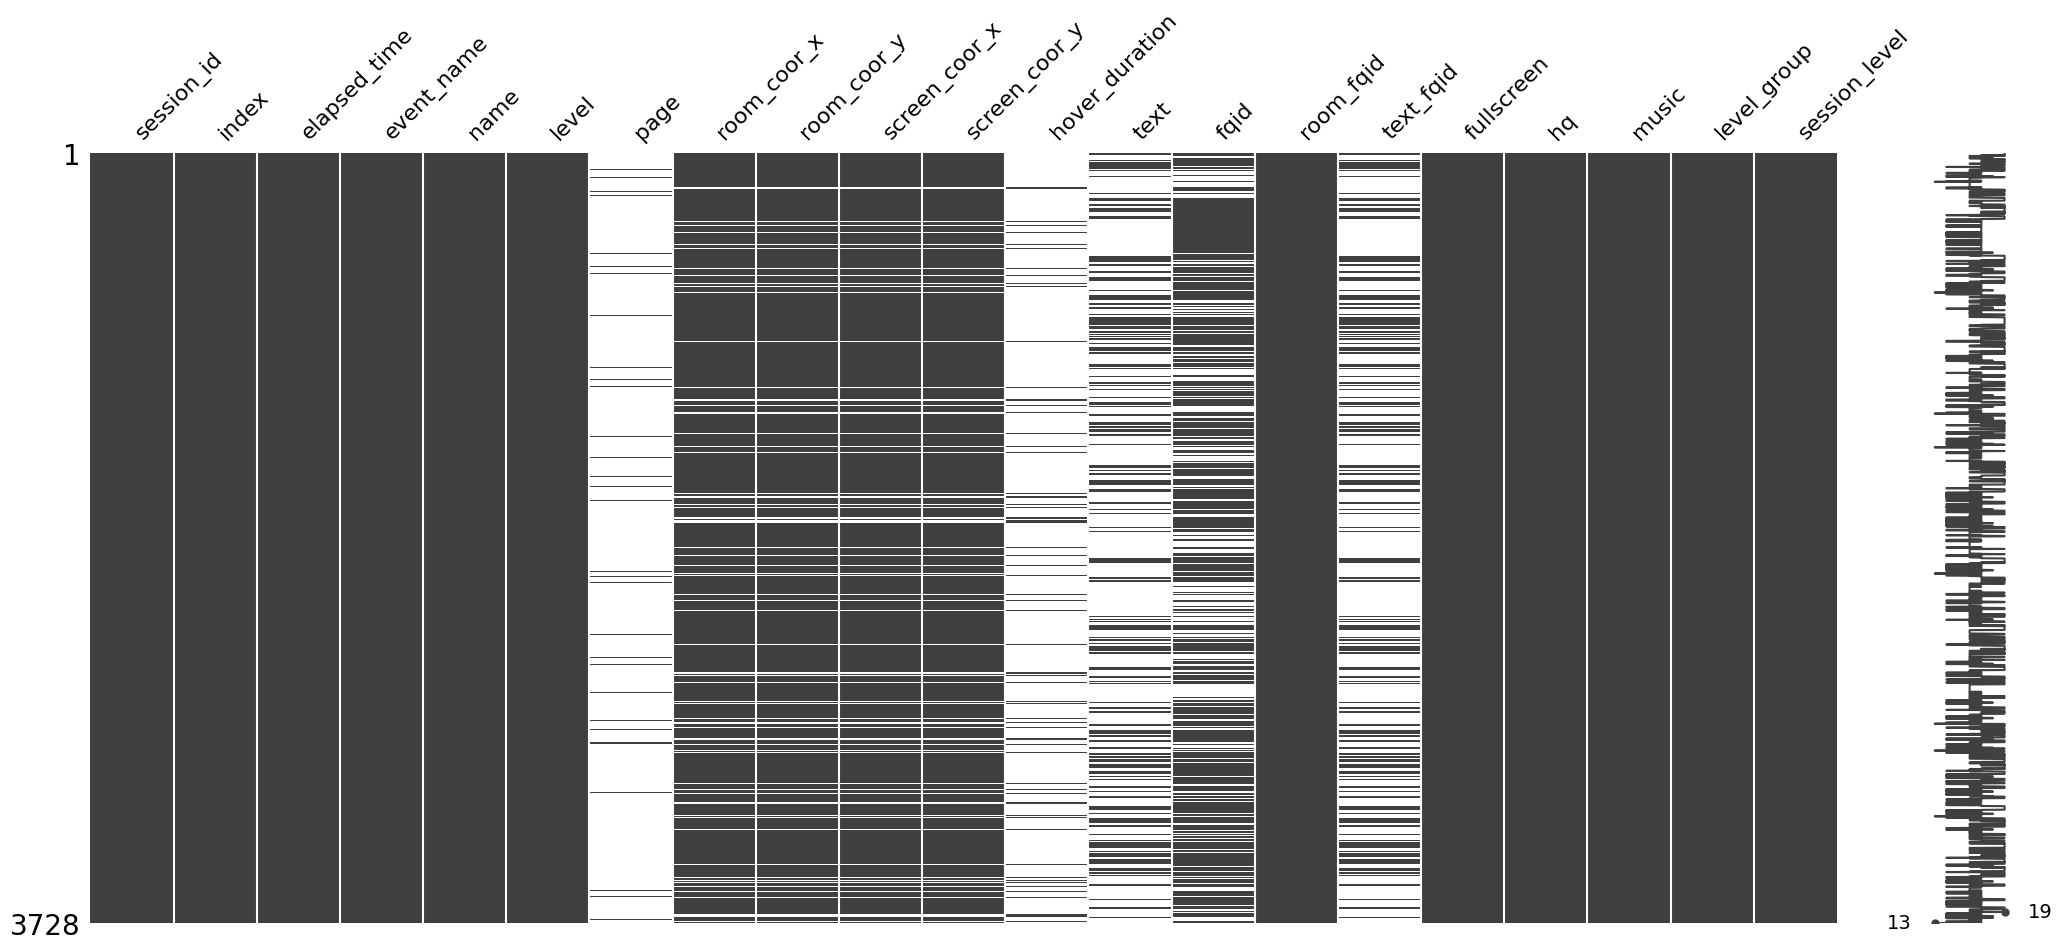

In [ ]:
missing_values = testdf.isnull().sum()
msno.matrix(testdf)
plt.show()

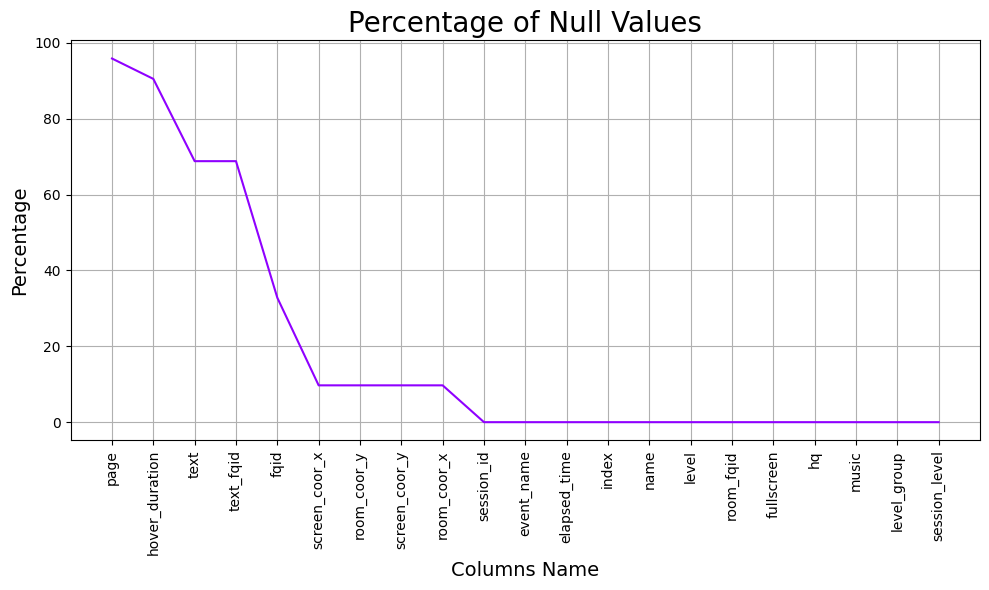

In [ ]:
#displaying the null value percentage by column
null_percentage = (missing_values / len(testdf)) * 100
null_percentage = null_percentage.round(2)

sorted_null_percentage = null_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(sorted_null_percentage.index, sorted_null_percentage.values, color='#8F00FF')

plt.title('Percentage of Null Values', fontsize=20)
plt.xlabel('Columns Name', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.grid(True)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# checking duplicated records
duplicates = testdf.duplicated().sum()
print('Number of Duplicated Entries: ',duplicates)

Number of Duplicated Entries:  0


In [ ]:
#DROP COL --- HAVEN"T EXECUTED
#?df = ?df.drop(['page', 'index', 'fullscreen', 'hq', 'music'], axis=1)

#dicts

In [ ]:
event_names = sorted([
    'cutscene_click',
    'person_click',
    'notification_click',
    'object_click',
    'object_hover',
    'map_hover',
    'navigate_click',
    'observation_click',
    'map_click',
    'checkpoint',
    'notebook_click',
])

#empty dict
event_dict = {}
for idx in range(len(event_names)):
    event_dict[event_names[idx]] = idx

for key, value in event_dict.items():
    print(f"{key}: {value}")


In [ ]:
from sklearn.preprocessing import LabelEncoder

roomid = sorted([
    'tunic.capitol_0.hall',
    'tunic.capitol_1.hall',
    'tunic.capitol_2.hall',
    'tunic.drycleaner.frontdesk',
    'tunic.flaghouse.entry',
    'tunic.historicalsociety.basement',
    'tunic.historicalsociety.cage',
    'tunic.historicalsociety.closet',
    'tunic.historicalsociety.closet_dirty',
    'tunic.historicalsociety.collection',
    'tunic.historicalsociety.collection_flag',
    'tunic.historicalsociety.entry',
    'tunic.historicalsociety.frontdesk',
    'tunic.historicalsociety.stacks',
    'tunic.humanecology.frontdesk',
    'tunic.kohlcenter.halloffame',
    'tunic.library.frontdesk',
    'tunic.library.microfiche',
    'tunic.wildlife.center'
])

encoder = LabelEncoder()
encoded = encoder.fit_transform(roomid)

for room, code in zip(roomid, encoded):
    print(f"{room}: {code}")
#below is the dict

In [ ]:
roomid = sorted([
    'tunic.capitol_0.hall',
    'tunic.capitol_1.hall',
    'tunic.capitol_2.hall',
    'tunic.drycleaner.frontdesk',
    'tunic.flaghouse.entry',
    'tunic.historicalsociety.basement',
    'tunic.historicalsociety.cage',
    'tunic.historicalsociety.closet',
    'tunic.historicalsociety.closet_dirty',
    'tunic.historicalsociety.collection',
    'tunic.historicalsociety.collection_flag',
    'tunic.historicalsociety.entry',
    'tunic.historicalsociety.frontdesk',
    'tunic.historicalsociety.stacks',
    'tunic.humanecology.frontdesk',
    'tunic.kohlcenter.halloffame',
    'tunic.library.frontdesk',
    'tunic.library.microfiche',
    'tunic.wildlife.center'
])

roomid_dict = {fqid: idx for idx, fqid in enumerate(roomid)}

for key, value in roomid_dict.items():
    print(f"{key}: {value}")


In [ ]:
buildings = sorted([
    'capitol_0',
    'capitol_1',
    'capitol_2',
    'drycleaner',
    'flaghouse',
    'historicalsociety',
    'humanecology',
    'kohlcenter',
    'library',
    'wildlife',
])
build_dict = {fqid: idx for idx, fqid in enumerate(buildings)}

for key, value in build_dict.items():
    print(f"{key}: {value}")


In [46]:
textcount = traindf['text'].value_counts()
uniquetext = textcount.index.tolist()

print("Text Counts:")
print(textcount)
print("\nUnique Text:")
print(uniquetext)

Text Counts:
text
undefined                                      355969
\u00f0\u0178\u02dc\u0090                        48805
Hey!                                            47452
I should go to the Capitol and tell Mrs. M!     40463
This is perfect for the exhibit.                40218
                                                ...  
Sorry I'm late.                                     1
He needs our help!                                  1
Now can I tell you what happened to Teddy?          1
I knew you could do it, Jo!                         1
AND he stole Teddy!                                 1
Name: count, Length: 597, dtype: int64

Unique Text:
['undefined', '\\u00f0\\u0178\\u02dc\\u0090', 'Hey!', 'I should go to the Capitol and tell Mrs. M!', 'This is perfect for the exhibit.', 'Look at all those activists!', "If I were you, I'd go to the library and do some digging.", 'Ugh. Fine.', '\\u00f0\\u0178\\u02dc\\u00b4', 'You can talk to a textile expert there.', "Hey Jo, let's t

#correlation

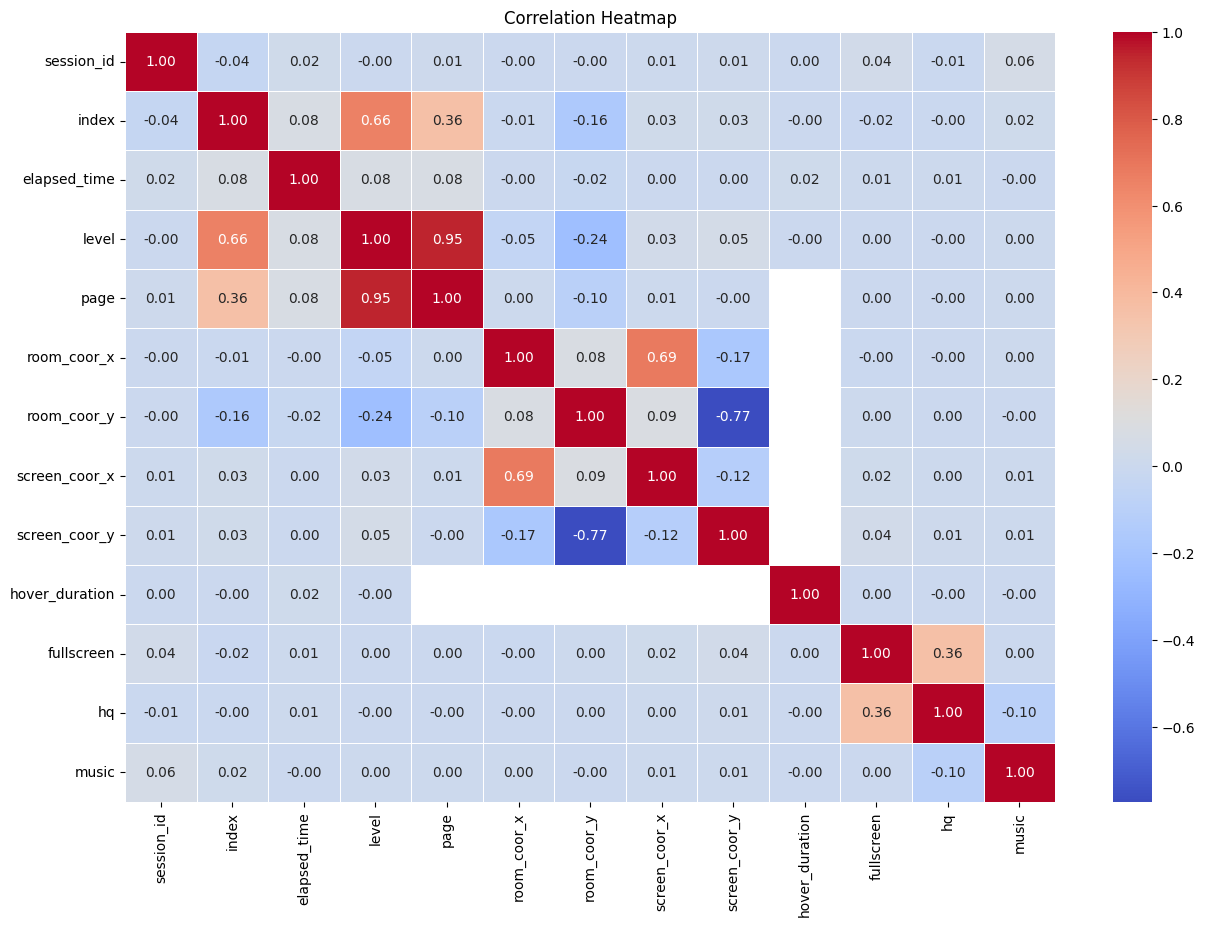

In [ ]:
numeric_df = traindf.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

##correlation insights for numeric data
####The above correlation matrix heatmap helps further understanding about what features to select and what to drop. In this case, hq, music, and fullscreen appear to not have enough data to be worth keeping. Hover_duration is also partially missing some data points.


####We can also see what variables strongly correlate with each other
####level/page with index, level with page, room_coor_y with screen_coor_y, screen_coor_x with room_coor_x. The room and screen coor variables give more insight into consistency with the room of the game fitting the screen of the game, rather than the player's ability itself.

hover_duration - how long (in milliseconds) the hover happened for (only for hover events) (map and object hover)
fullscreen - whether the player is in fullscreen mode
hq - whether the game is in high-quality
music - whether the game music is on or off

#feature info

In [ ]:
import pandas as pd

feature_info = [] #stores information about each feature

for column in traindf.columns:
    if traindf[column].dtype == 'object' or traindf[column].nunique() < 10:
        feature_type = 'Categorical'
        values = traindf[column].unique()
        value_range = ','.join(map(str, values))
    else:
        feature_type = 'Numerical'
        min_value = traindf[column].min()
        max_value = traindf[column].max()
        value_range = f"{min_value} to {max_value}"

    feature_info.append([column, feature_type, value_range])

featuri = pd.DataFrame(feature_info, columns=['Feature', 'Type', 'Values/Range'])
print(featuri)


           Feature         Type  \
0       session_id    Numerical   
1            index    Numerical   
2     elapsed_time    Numerical   
3       event_name  Categorical   
4             name  Categorical   
5            level    Numerical   
6             page  Categorical   
7      room_coor_x    Numerical   
8      room_coor_y    Numerical   
9    screen_coor_x    Numerical   
10   screen_coor_y    Numerical   
11  hover_duration    Numerical   
12            text  Categorical   
13            fqid  Categorical   
14       room_fqid  Categorical   
15       text_fqid  Categorical   
16      fullscreen  Categorical   
17              hq  Categorical   
18           music  Categorical   
19     level_group  Categorical   

                                         Values/Range  
0              20090312431273200 to 22100221145014656  
1                                          0 to 20473  
2                                     0 to 1988606704  
3   cutscene_click,person_click,navigate

#basic graphs with sns to get an overall picture

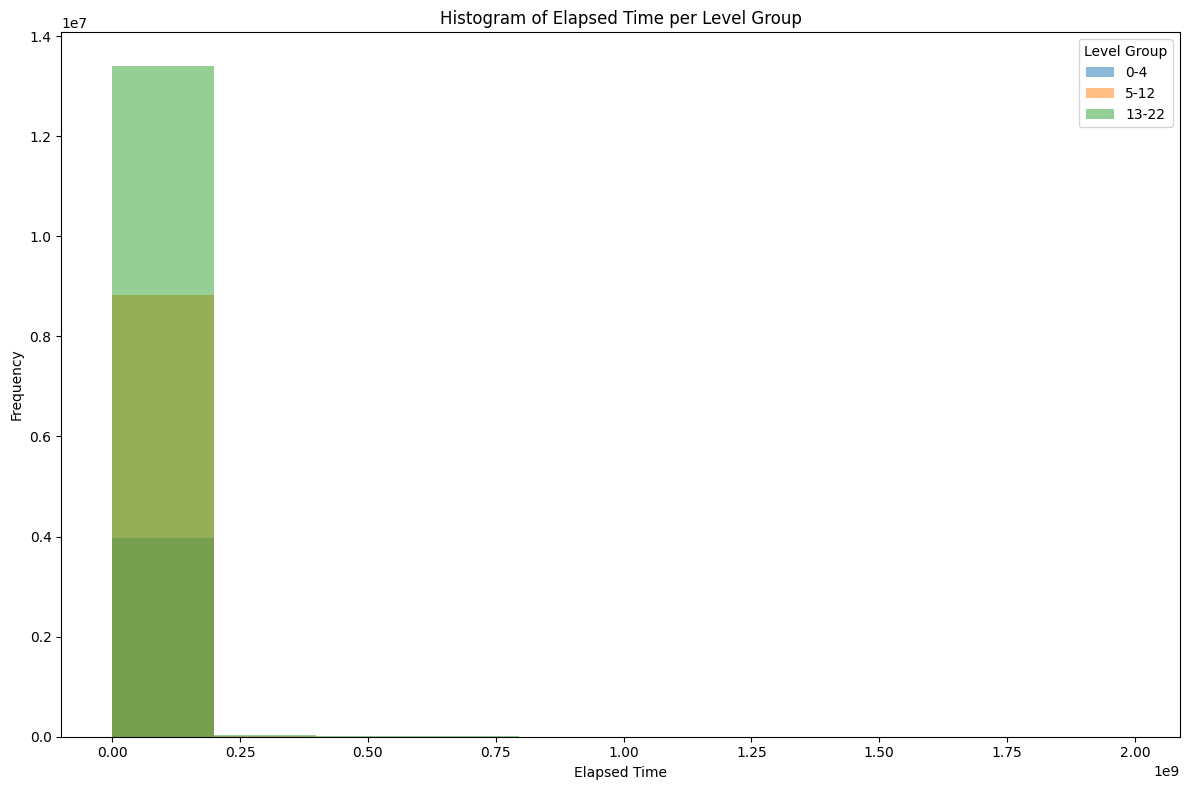

In [ ]:
level_groups = traindf['level_group'].unique()

plt.figure(figsize=(12, 8))

for level in level_groups:
    subset = traindf[traindf['level_group'] == level]
    plt.hist(subset['elapsed_time'], bins=10, alpha=0.5, label=level)


plt.xlabel('Elapsed Time')
plt.ylabel('Frequency')
plt.title('Histogram of Elapsed Time per Level Group')
plt.legend(title='Level Group')

plt.tight_layout()
plt.show()

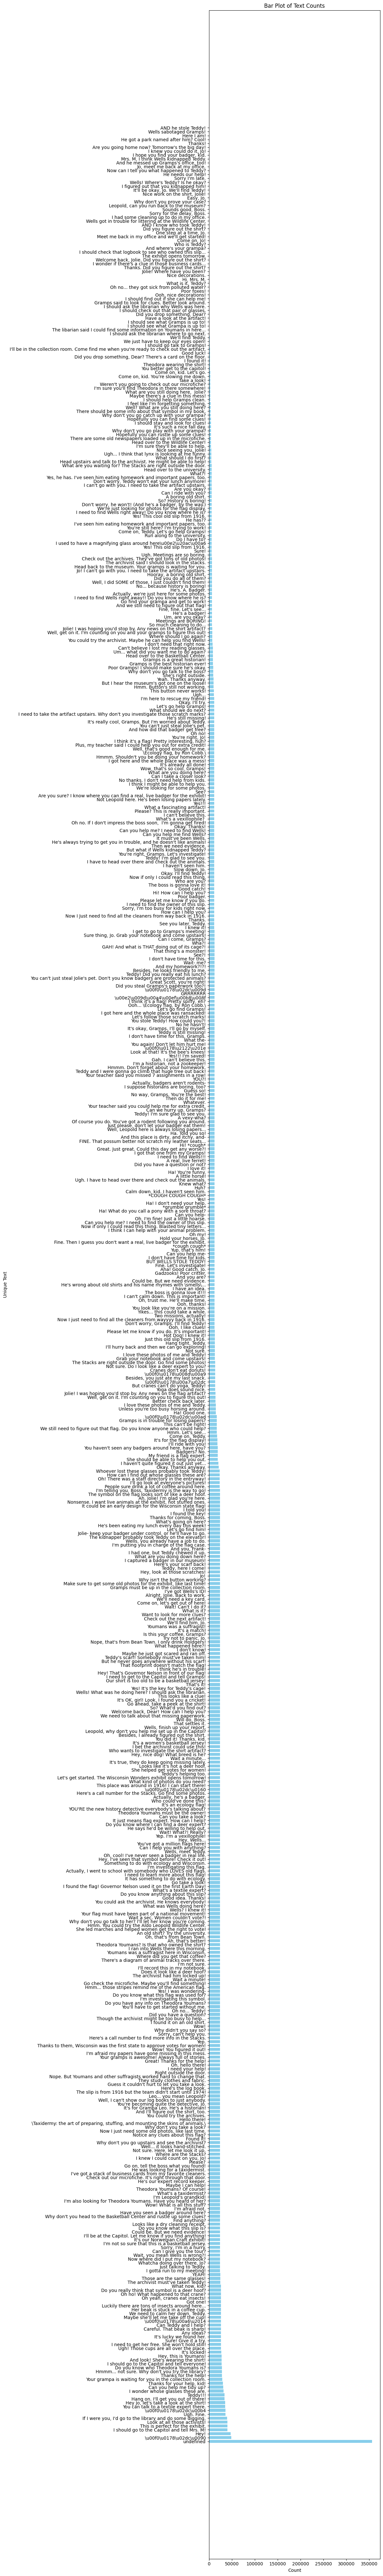

In [ ]:
plt.figure(figsize=(12, 80))
plt.barh(uniquetext, textcount, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Unique Text')
plt.title('Bar Plot of Text Counts')
plt.tight_layout()
plt.show()
#this is objectively awful, do I need to group texts somehow? what variable am i even pairing with texts to learn something?

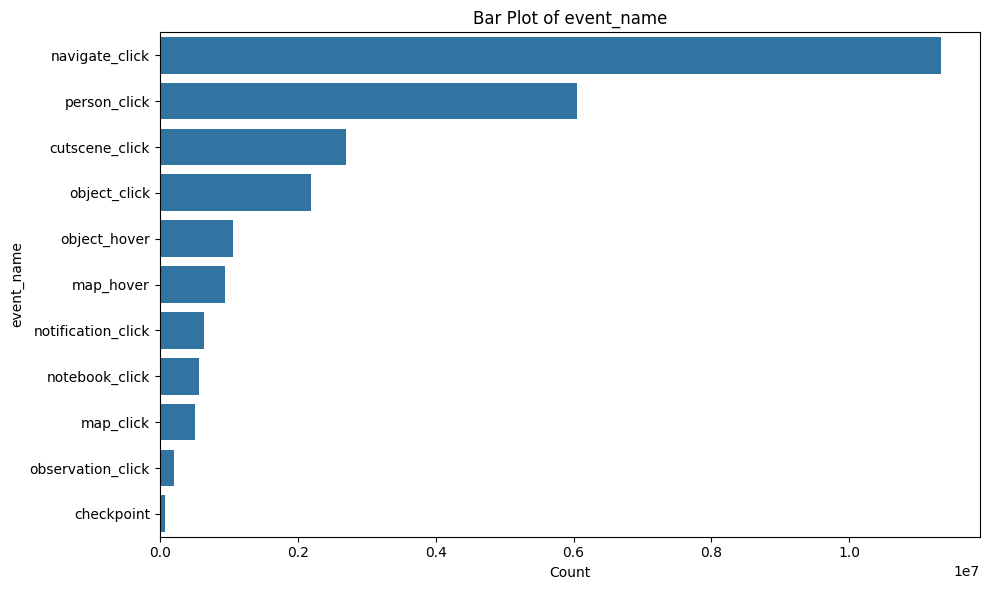

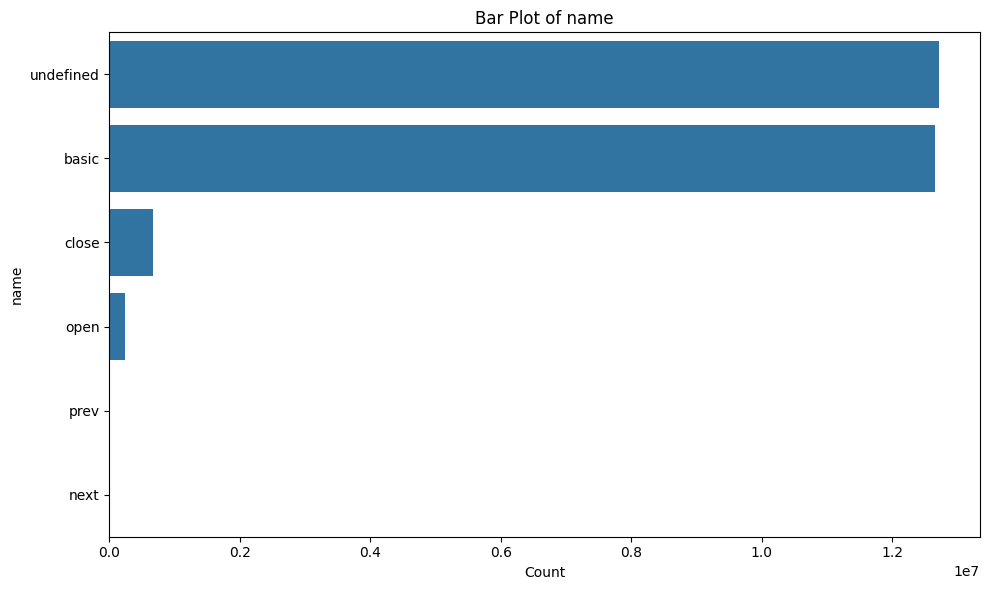

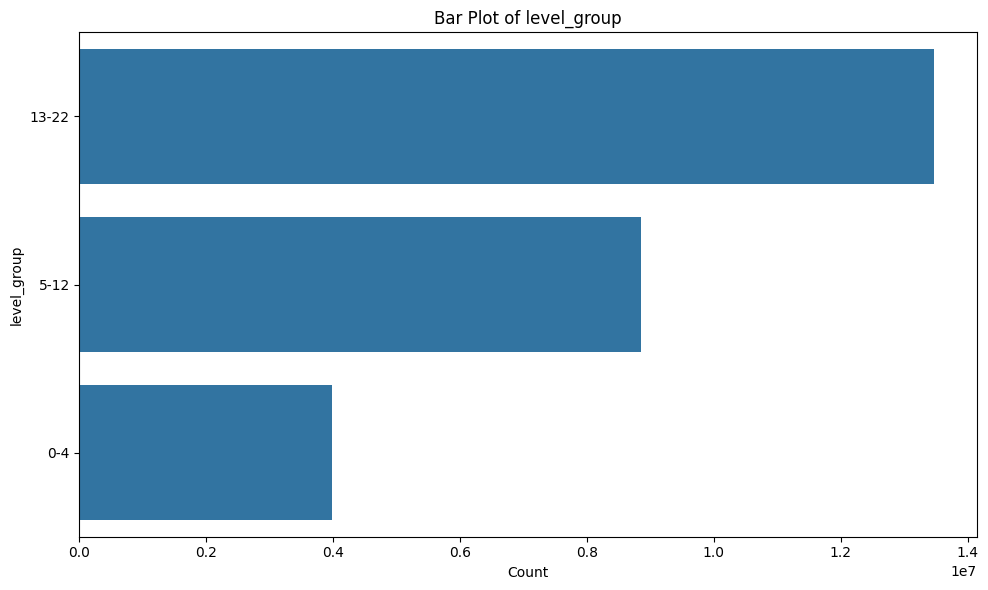

In [ ]:
#exclude
columns_to_exclude = ['text', 'fqid', 'room_fqid', 'text_fqid']

categorical_columns = [col for col in traindf.select_dtypes(include=['object']).columns if col not in columns_to_exclude]

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=traindf, order=traindf[column].value_counts().index)
    plt.title(f'Bar Plot of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


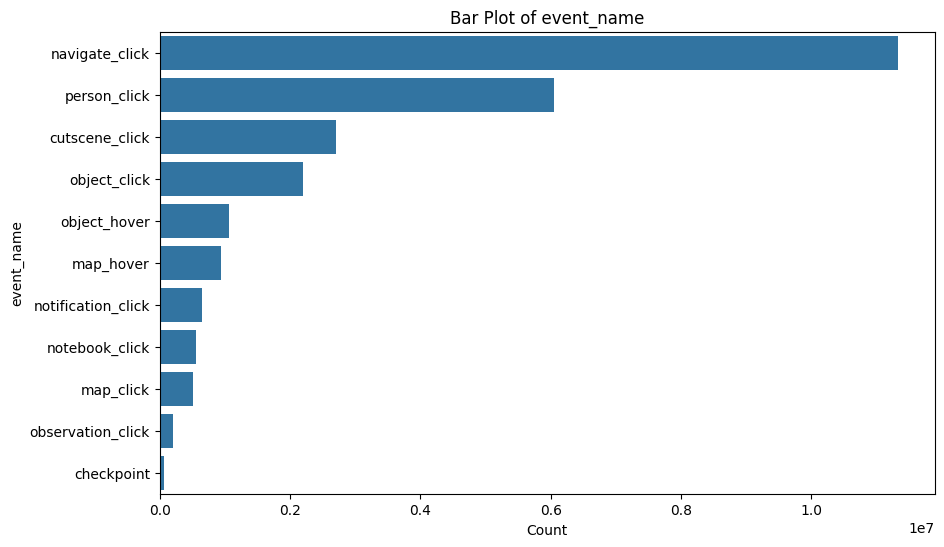

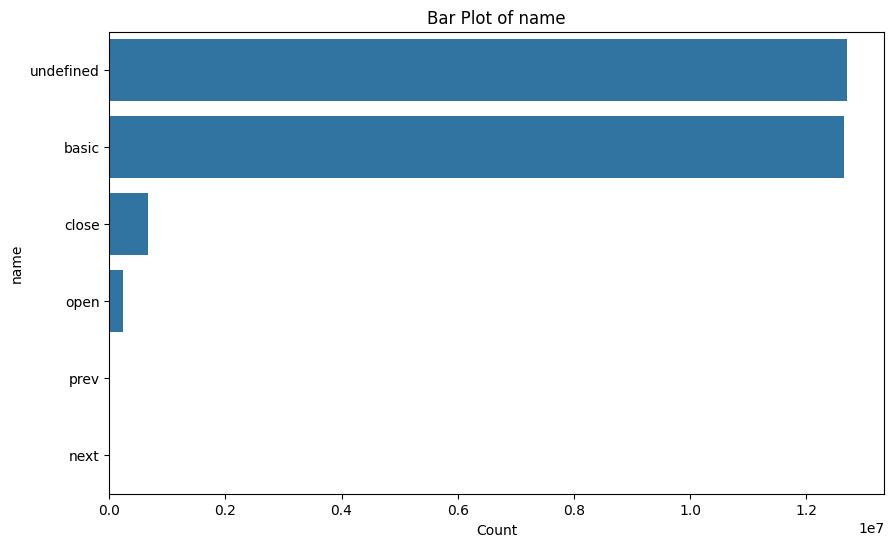

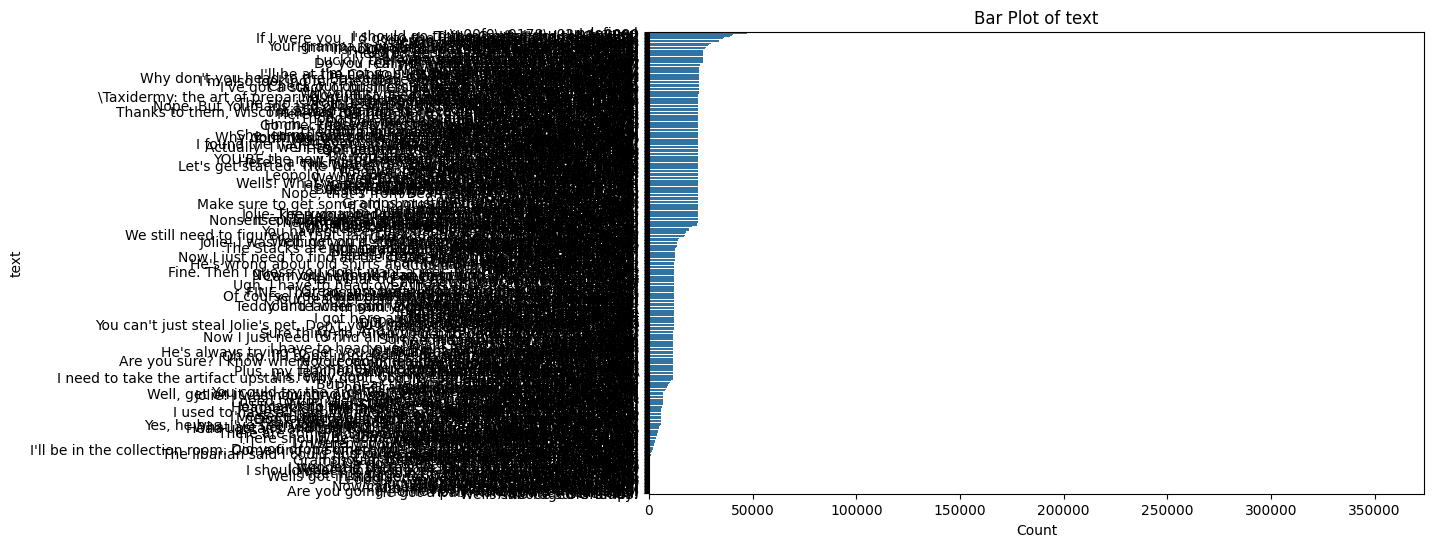

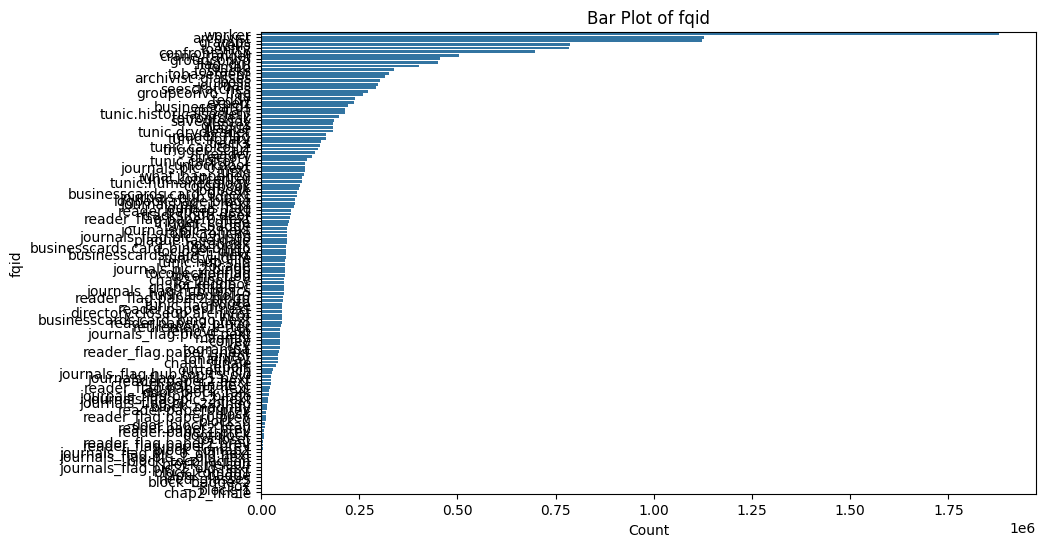

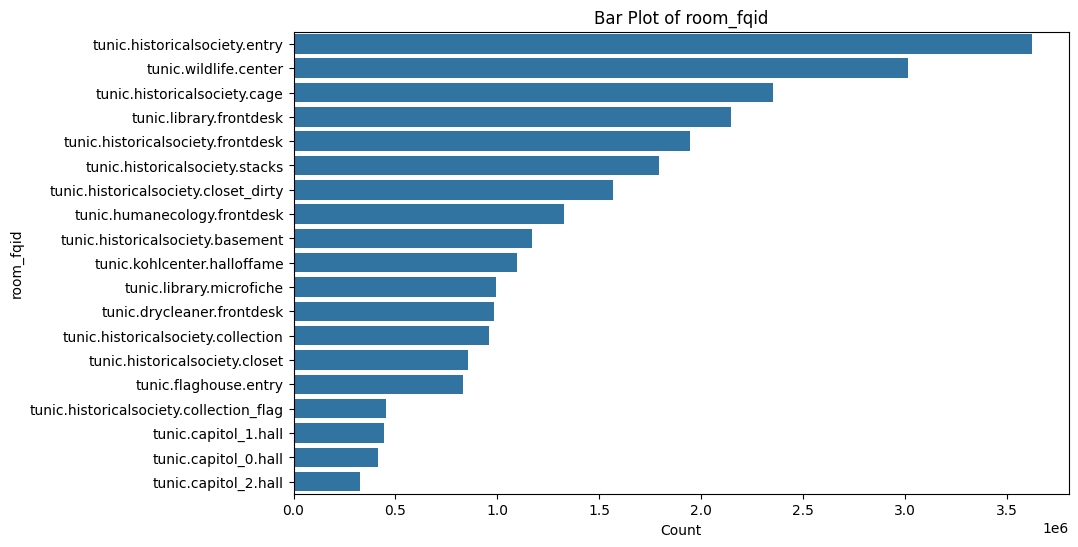

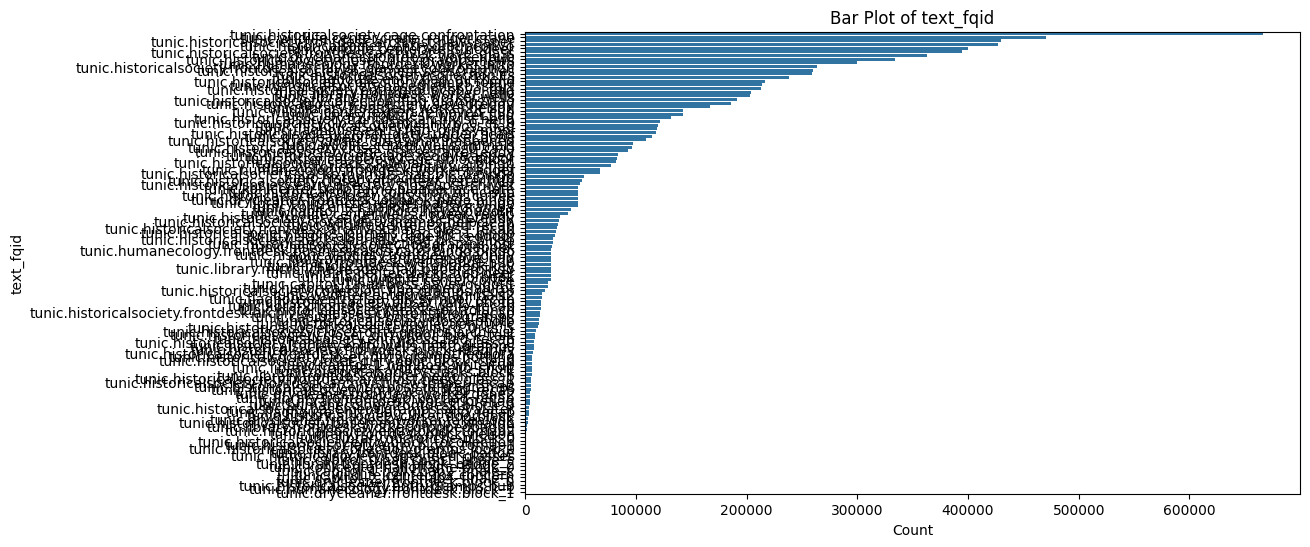

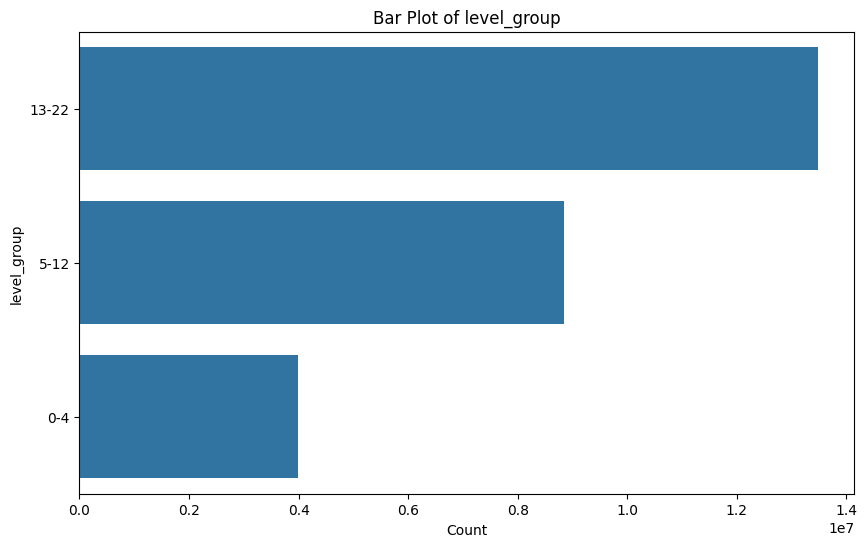

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_columns = traindf.select_dtypes(include=['object']).columns

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=traindf, order=traindf[column].value_counts().index)
    plt.title(f'Bar Plot of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()
###take out overlapping text, encode it with keys to make easier to read

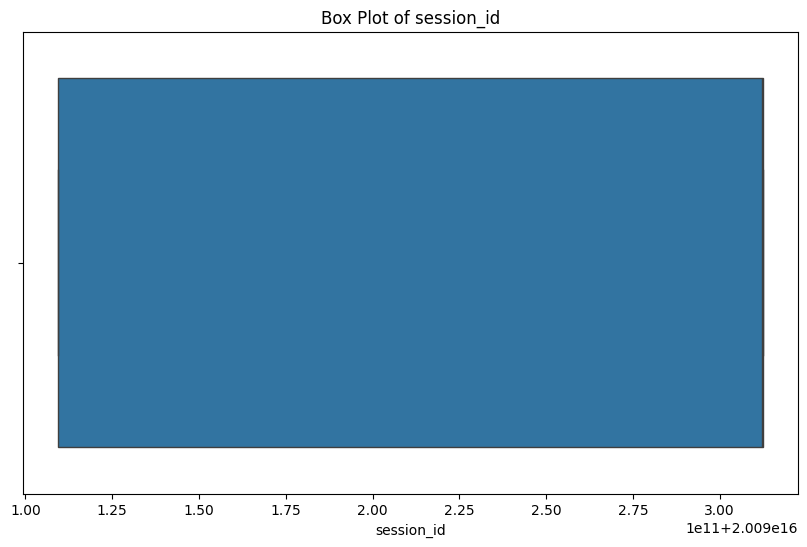

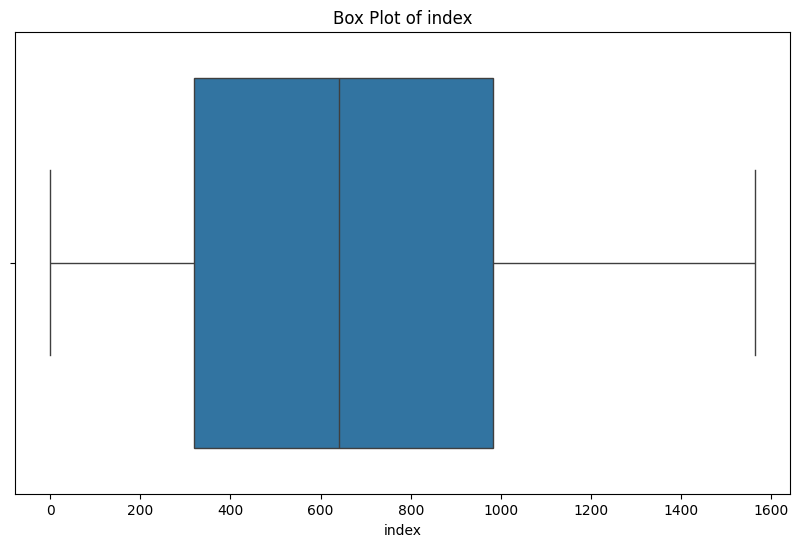

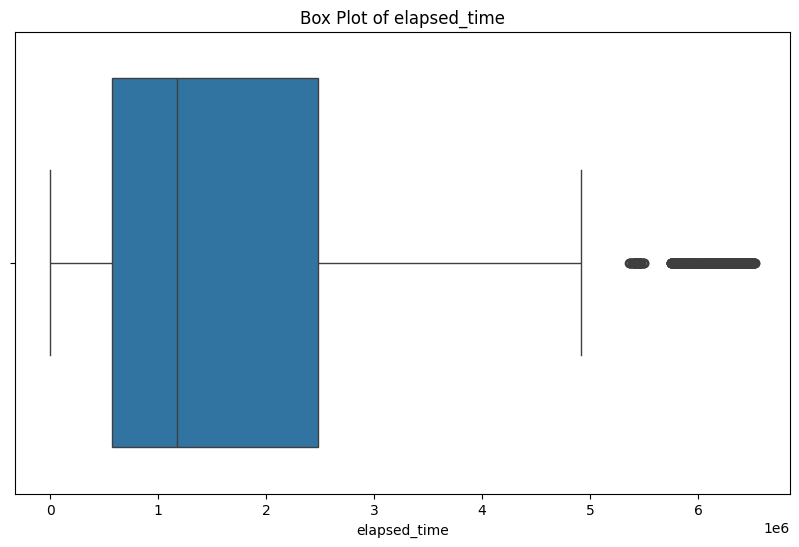

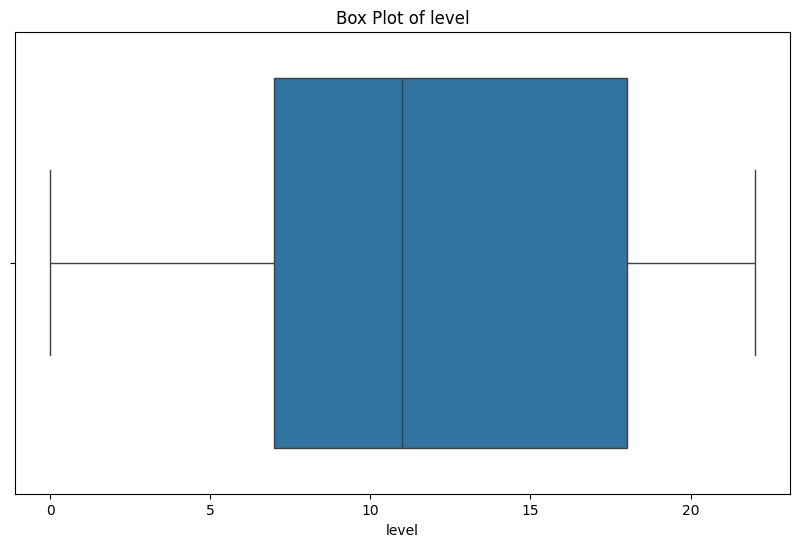

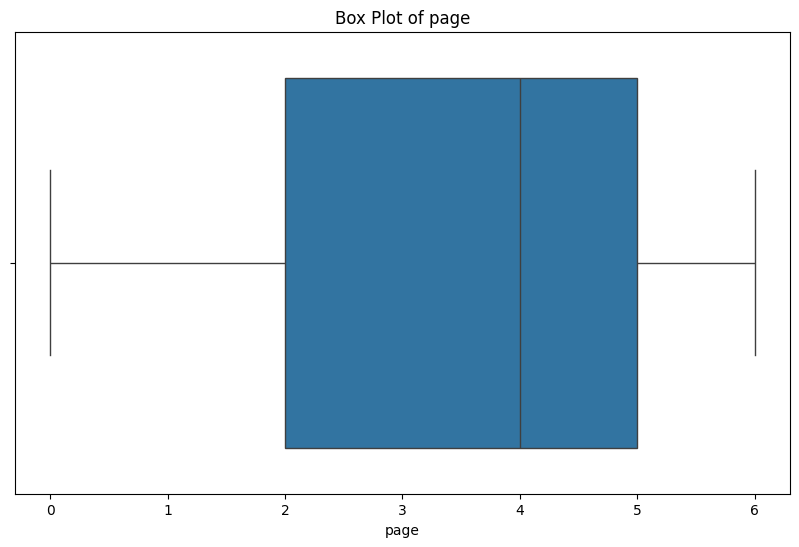

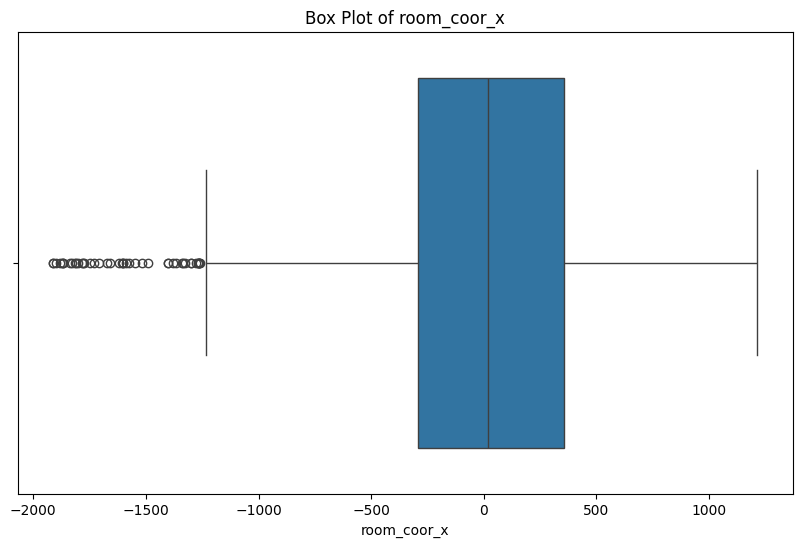

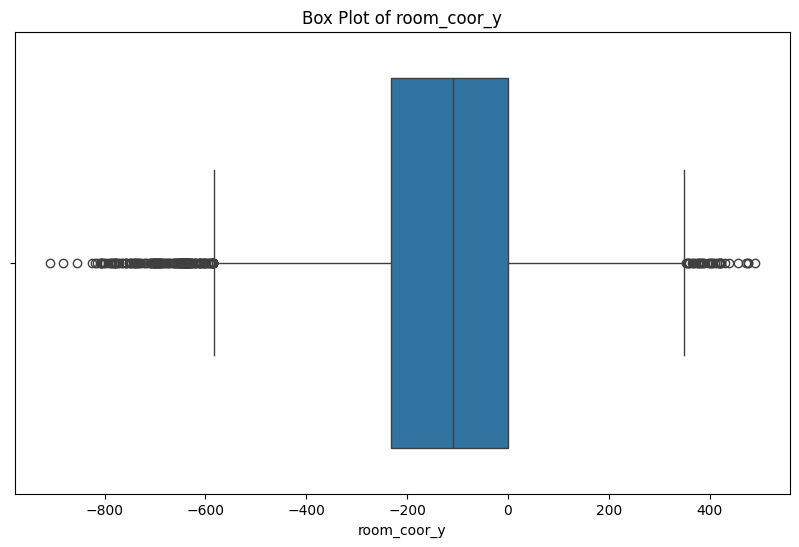

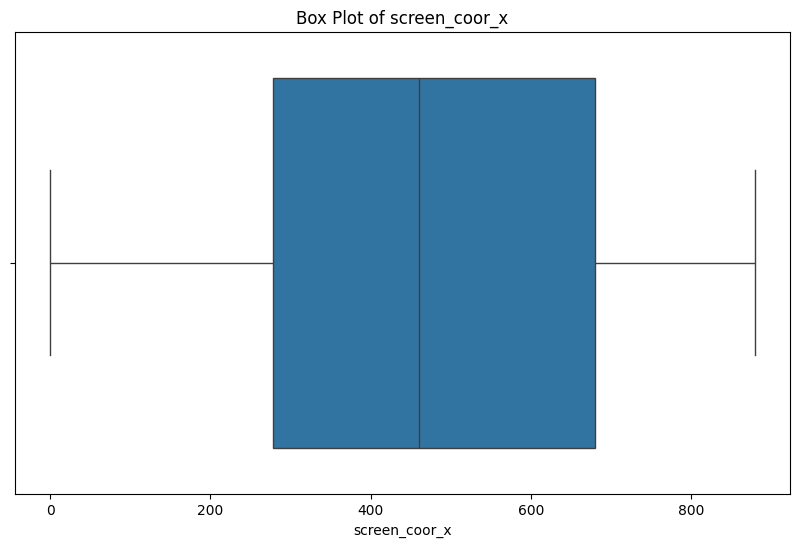

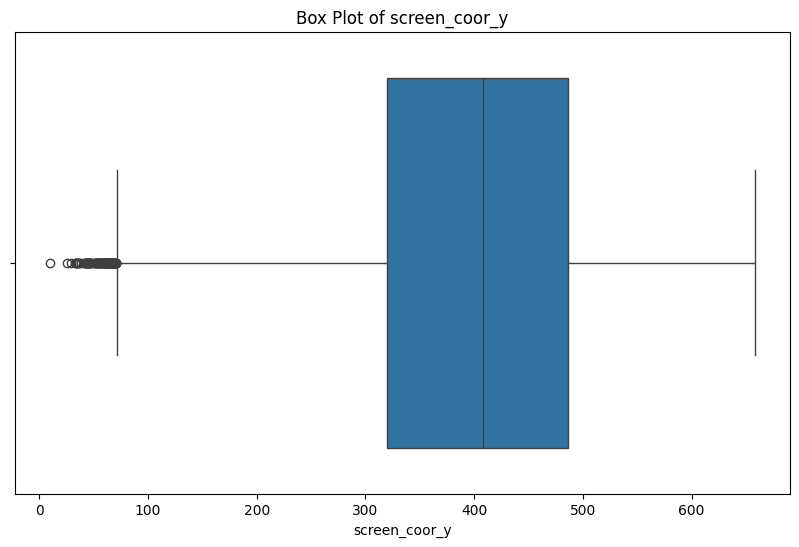

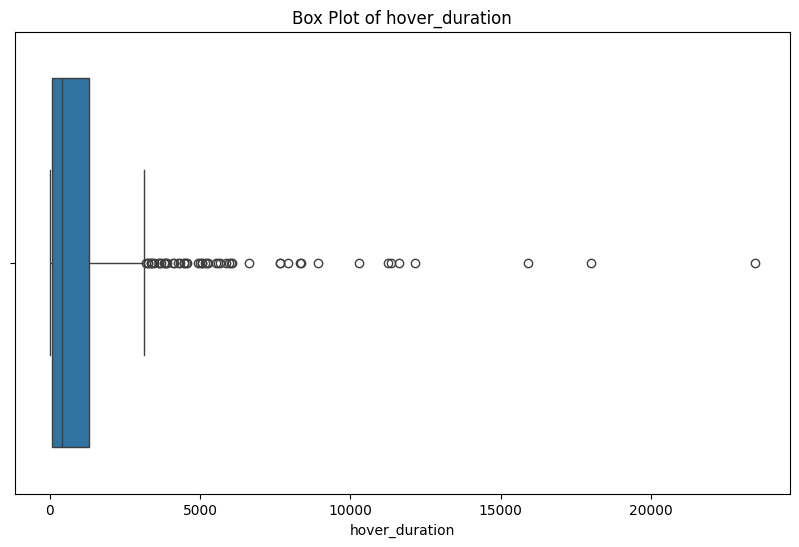

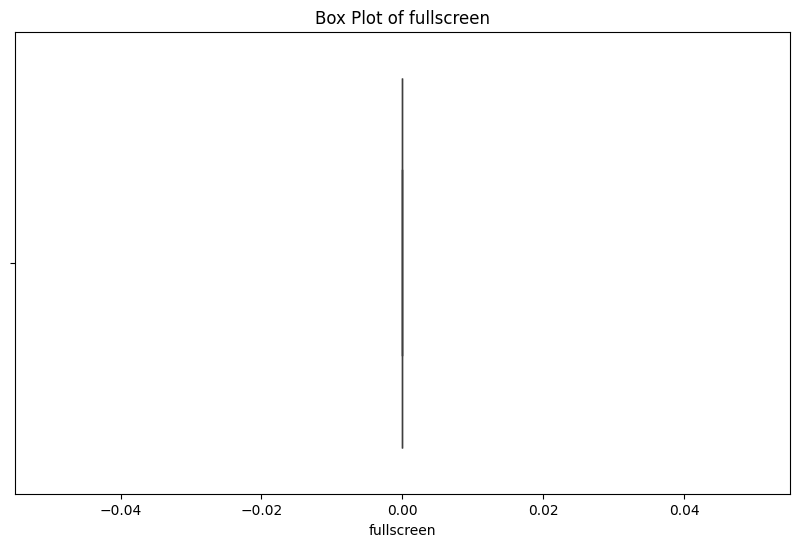

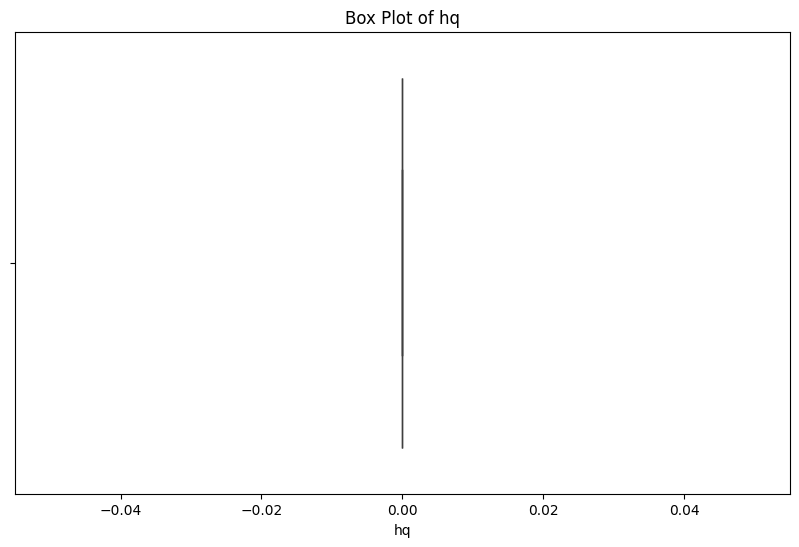

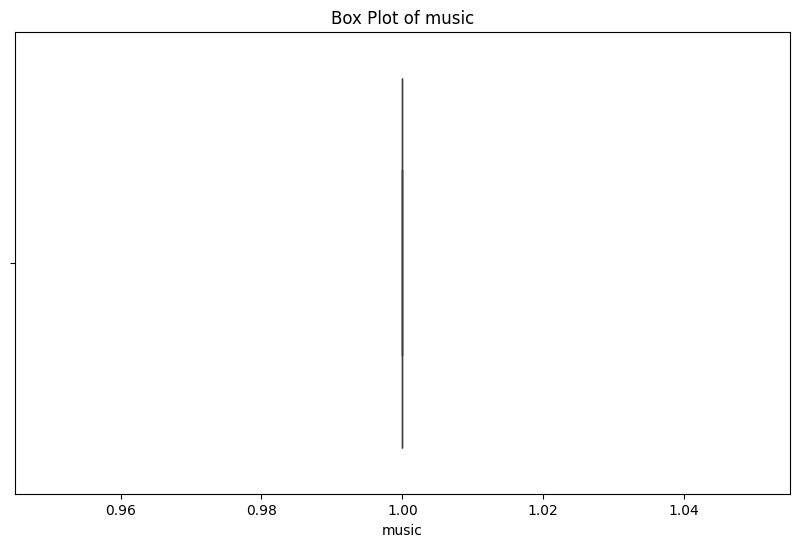

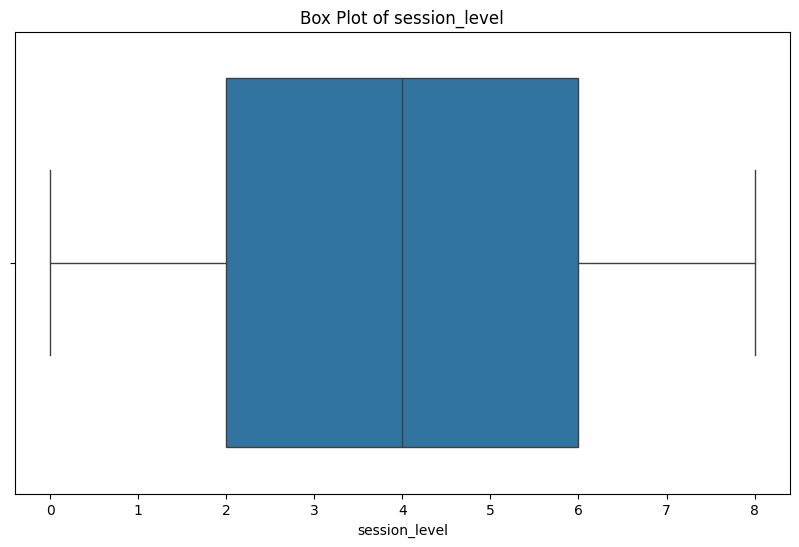

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


numerical_columns = testdf.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=testdf[column])
    plt.title(f'Box Plot of {column}')
    plt.show()


In [ ]:
from scipy.stats import zscore

z_scores = testdf[numerical_columns].apply(zscore)
threshold = 2.5
outliers = (z_scores > threshold) | (z_scores < -threshold)

print(testdf[outliers.any(axis=1)])


Empty DataFrame
Columns: [session_id, index, elapsed_time, event_name, name, level, page, room_coor_x, room_coor_y, screen_coor_x, screen_coor_y, hover_duration, text, fqid, room_fqid, text_fqid, fullscreen, hq, music, level_group, session_level]
Index: []

[0 rows x 21 columns]


In [ ]:
Q1 = testdf[numerical_columns].quantile(0.25)
Q3 = testdf[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

outliers = ((testdf[numerical_columns] < (Q1 - 1.5 * IQR)) | (testdf[numerical_columns] > (Q3 + 1.5 * IQR)))
print(testdf[outliers.any(axis=1)])


             session_id  index  elapsed_time      event_name       name  \
24    20090109393214576     24         36597    object_click      close   
42    20090109393214576     42         76680    object_click      close   
67    20090109393214576     67        116880    object_hover  undefined   
68    20090109393214576     68        117529    object_click      close   
80    20090109393214576     80        139212  notebook_click      close   
...                 ...    ...           ...             ...        ...   
3691  20090312331414616    969       1545814    object_hover  undefined   
3696  20090312331414616    974       1550010    object_hover  undefined   
3703  20090312331414616    981       1554772    object_hover  undefined   
3704  20090312331414616    982       1555421    object_click      close   
3712  20090312331414616    990       1569440  notebook_click      close   

      level  page  room_coor_x  room_coor_y  screen_coor_x  ...  \
24        0   NaN  -207.643017  

Most likely to be predictive features: task completion time, event reaction time, question number, total events for a level group, time player spent at initial level maybe? number of clicks per event if they answered the question right?
trying to predict correctness based off of previous patterns of interaction with the game